# Lesson 10 - Neighbours and clusters

> Use distance measures to classify and cluster data.

## Learning objectives
In this lesson we will have a look at distance and similarity measures to analyse data. If one can determine the distance between data samples (e.g. between rows in a table, different texts or images) one has access to a range of tools to investigate data and to model it. In this lesson we will have a look at two of them, namely k-nearest neighbour classification and k-means clustering. 

* **k-nearest neighbour** classification falls in the category of supervised algorithms, which we already encountered with Decision Trees and Random Forests.

* **k-means** clustering on the other hand is an unsupervised method and therefore forms a new class of algorithms. We will investigate how these algorithms can be used.

This notebook is split according to three learning goals:
1. Understand different measures of distance and the curse of dimensionality.
2. How the nearest neighbours can be used to build a classifier in scikit-learn.
3. Explore a dataset with the unsupervised k-means method.

## References
* Chapter 6: Similarity, Neighbors, and Clusters of _Data Science for Business_ by F. Provost and P. Fawcett

## Homework
Work through the notebook and solve the exercises.

## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock

## Helper Libraries (L. von Werra)

In [6]:
def plot_classifier_boundaries(X, y, clf):
    """
    Given features X and labels y along with classifier, plot decision boundaries in two dimensions.
    
    Args:
        X: feature array of shape (n_samples, n_features)
        y: label array of shape (n_samples)
    """
    
    h = .02  # step size in the mesh

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=1)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Part 1: Similarity and distance measures

Similarity and distance measures are fundamental tools in machine learning. Often we want to know how far apart or similar two datapoints are. Some examples:

* How similar are two customers?
* How similar are two pictures?
* How far away is the closest restaurant?

How we measure the distance and similarity influences the results. If the direct, shortest path takes us over a cliff it might not actually be the shortest path time-wise. Also the dimensionality of the data has an impact on the usefulness of the result. When working with high-dimensional data one has to keep the _curse of dimensionality_ in mind that impacts the quality of some metrics.

In this section we investigate **how different measures of distance and similarity behave when more dimensions are added**. In machine learning this means that we add more features to the feature matrix. This can have **severe implications on the quality of distance measure and methods that rely on it (such as k-nearest neighbour or k-means)**. This is often called the **curse of dimensionality**.

First lets define a few distance/similarity measures. These functions calculate the distance/similarity between two vectors `x` and `y`:

In [7]:
def euclidean_distance(x, y):  # see https://en.wikipedia.org/wiki/Euclidean_distance
    """calculate euclidean distance between two arrays."""
    return np.linalg.norm(x-y) 


def cos_similarity(x, y):      # see https://en.wikipedia.org/wiki/Cosine_similarity
    """calculate cosine similarity between two arrays."""
    cos_sim = np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y)) 
    return cos_sim


def manhatten_distance(x, y):  # see https://en.wikipedia.org/wiki/Taxicab_geometry
    """calculate manhatten distance between two arrays."""
    ################
    # YOUR CODE    #
    # (Exercise 1) #
    ################
    manhatten_dist= cityblock(x,y)

    return manhatten_dist

Now we create pairs of random vectors with dimensionality ranging from 1 to 10000 (In other words, we create pairs of rows in our feature matrix X for cases where the feature matrix has 1 to 10000 columns, i.e. 1 to 10000 features). For each dimension (i.e. for each of the 10000 cases), we calculate the distance between the two vectors and store them in a list:

In [8]:
euclidean_distances = []
cos_distances = []
manhatten_distances = []

dims = np.linspace(1, 10000, 1000).astype(int) # 1000 intervals betw 1 and 10000

for dim in dims:
    x = np.random.rand(dim) # random vector of length dim with entries between 0 and 1 
    y = np.random.rand(dim)
    
    euclidean_distances.append(euclidean_distance(x, y))
    cos_distances.append(cos_similarity(x, y))
    manhatten_distances.append(manhatten_distance(x, y))

How this distance between x and y depends on the dimension (i.e. on the number of features) can be plotted in a graph:

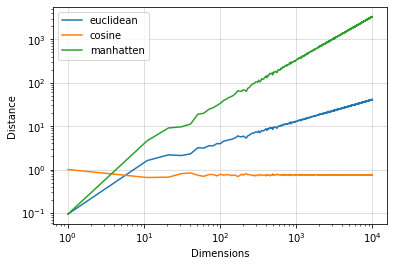

In [9]:
plt.plot(dims, euclidean_distances, label='euclidean')
plt.plot(dims, cos_distances, label='cosine')
plt.plot(dims, manhatten_distances, label='manhatten')
plt.ylabel('Distance')
plt.xlabel('Dimensions')
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.grid(True,alpha=0.5)
plt.show()

### Exercise 1
Implement the Manhatten-metric and add it to the scaling plot. The mathematical definition of the Manhatten-metric is:

$d_{Manhatten}(\vec{x},\vec{y})=\sum_{i=1}^{n}{\mid x_i - y_i \mid}$

Use the plot to investigate the following questions:

* How does it behave compared to the other two metrics? 
* What do you observe when you plot the y-axis on a linear scale (comment the line `plt.yscale('log')`)?

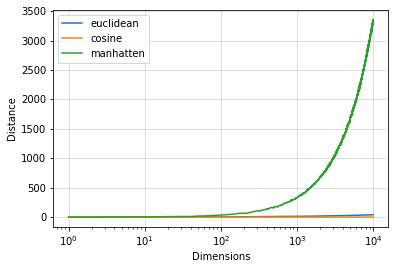

In [10]:
#only plotting every 10th point to increase performance
plt.plot(dims, euclidean_distances, label='euclidean')
plt.plot(dims, cos_distances, label='cosine')
plt.plot(dims, manhatten_distances, label='manhatten')
plt.ylabel('Distance')
plt.xlabel('Dimensions')
plt.legend(loc='best')
#plt.yscale('log')
plt.xscale('log')
plt.grid(True,alpha=0.5)
plt.show()

## Part 2: k-nearest neighbours

### Iris dataset

The iris dataset contains the [sepal width and the petal width](https://en.wikipedia.org/wiki/Petal#/media/File:Petal-sepal.jpg) of three species of flowers. The three species are Iris setosa, Iris versicolor, and Iris virginica. It is one of the most iconic datasets in machine learning and has been around for more than 80 years! It is still widely used today: Because of its two features it is easy to visualise and study different algorithms on it. Going beyond 2 or 3 dimensions is very hard to visualise and we will study some methods in the next lesson to break down and visualise high dimensional data. For visualisation purposes we'll use the iris dataset in this lesson.


In [11]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

### k-nearest neighbours classifier

The k-nearest neighbours classifier uses the neighbours of a sample to classify it. Given a new point, it searches the k samples in the training set that are closest to the new point. Then the majority class of the neighbours is used to classify the new point. 

#### Example
Let's assume you are given a new flower and want to classify it using the iris dataset. You measure the petal and sepal width of your flower and compare it to the dataset. You decide to do a k=8 nearest neighbour search. You find that the nearest samples are:
* 5 Iris setosa
* 2 Iris versicolor
* 1 Iris virginica

Based on that observation you decide that your flower is a **Iris setosa**.

#### Tips & tricks
* Make sure all features are scaled properly (e.g. see `sklearn.preprocessing.StandardScaler`)
* In case of binary target, use odd number for k to avoid ties
* Voting can be weighted by distance

#### Usage
The `KNeighborsClassifier` interface is the same as the one we have already seen for the Decision Tree and Random Forest classifiers. When initializing the classifier one has to pass the number of neighbours `k` and can then use the known `.fit()` and `.predict()` procedure. We introduce the `plot_classifier_boundaries` to study the behaviour of the classifier more closely. 

> Note: The `plot_classifier_boundaries` function only works in two dimensions.

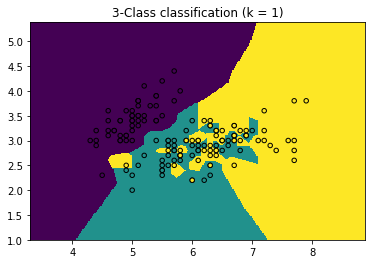

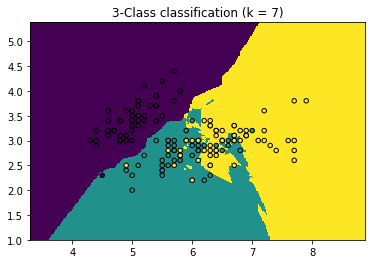

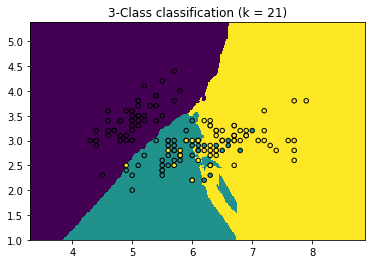

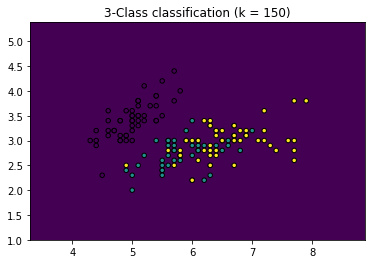

In [12]:
for k in [1, 7, 21, len(y)]:
    
    clf = KNeighborsClassifier(k)
    clf.fit(X, y)
    
    plot_classifier_boundaries(X, y, clf)
    plt.title(f"3-Class classification (k = {k})")
    plt.show()

### Excercise 2
Create the fitting graph for the `kNeighborsClassifier` on the iris dataset with cross-validation. Run it for the following values of k: `np.linspace(1, 120, 120,).astype(int)` and use 5 folds (`cv=5`). What is the best value for `k`? And how do you interpre k=1 and k=n_samples? When are you most likely to overfit the data?

In [13]:
def plot_fitting_graph(x, metric_train, metric_valid, metric_name='metric', xlabel='x', yscale='linear'):
    plt.plot(x, metric_train, label='train')
    plt.plot(x, metric_valid, label='valid')
    plt.yscale(yscale)
    plt.title('Fitting graph')
    plt.ylabel(metric_name)
    plt.xlabel(xlabel)
    plt.legend(loc='best')
    plt.grid(True)

In [14]:
ks : list = np.linspace(1,120,120).astype(int)
cv : int = 5

rmse_train : list = []
rmse_valid : list = []

for k in ks:
    
    clf = KNeighborsClassifier(k)
    result = cross_validate(
        clf, X, y,
        cv = 5,
        return_train_score= True,
        scoring = "neg_root_mean_squared_error"
        )
    clf.fit(X, y)

    rmse_train.append(-np.mean(result['train_score']))
    rmse_valid.append(-np.mean(result['test_score']))

    #plot_classifier_boundaries(X, y, clf)
    #plt.title(f"3-Class classification (k = {k})")
    #plt.show()

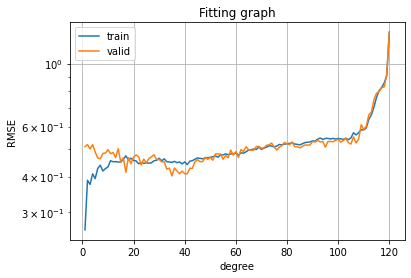

In [15]:
plot_fitting_graph(ks, rmse_train, rmse_valid, metric_name='RMSE', xlabel='degree', yscale='log')

In [16]:
optimal_k_valid : int = (rmse_valid.index(min(rmse_valid)) + 1 )
optimal_k_test : int = (rmse_train.index(min(rmse_train)) + 1 )

print("Optimal k for valid:\t", optimal_k_valid)
print("Optimal k for test:\t", optimal_k_test)

Optimal k for valid:	 35
Optimal k for test:	 1


### Excercise 3
Use the `plot_classifier_boundaries` to plot the classifier boundaries with the following settings:
* `RandomForestClassifier(n_estimators=1, max_depth=1)`
* `RandomForestClassifier(n_estimators=1, max_depth=2)` 
* `RandomForestClassifier(n_estimators=100, max_depth=None)`

What do you observe? Can you explain it?

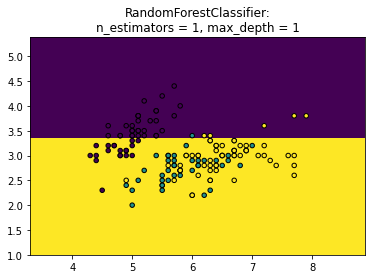

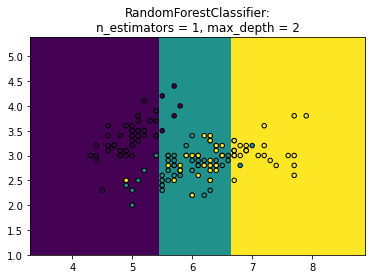

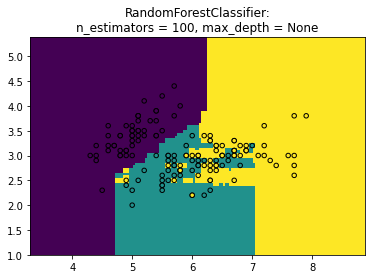

In [20]:
def ex3(X, y, args):

    for i in range(len(args)):

        clf = RandomForestClassifier(n_estimators= args[i][0], max_depth= args[i][1])
        clf.fit(X, y)

        plot_classifier_boundaries(X, y, clf)
        plt.title(f"RandomForestClassifier:\nn_estimators = {args[i][0]}, max_depth = {args[i][1]}")

ex3(X = X, y = y, args = [(1,1),(1,2),(100,None)])

The higher the depth on the trees, the more complex the clustering or classfifying becomes. The boundry goes from a split into two, to three, to three with a complicated border

## Part 3: k-means clustering

We now turn to k-means clustering, an unsupervised approach. The goal is to automatically identify clusters in the data without having access to the labels. We will see that even without knowledge about the data we will be able to make statements about the shape of it.

In [21]:
def plot_clustering_results(X, y, cluster_centers):
    """
    Plot results of k-means clustering.
    """
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.scatterplot(X[:,0], X[:,1],
                    hue=y, edgecolor='k',
                    palette="nipy_spectral",
                    legend=False)

    sns.scatterplot(cluster_centers[:, 0], cluster_centers[:, 1],
                    hue=list(range(np.shape(cluster_centers[:, 0])[0])),
                    palette="nipy_spectral", marker="o", edgecolor='k',
                    s=250, legend=False)
    plt.show()

The interface of k-mean provided in scikit-learn is very similar to that of a classifier.

**Initialize:**
We define the number of clusters we want to look for.
 ```python
    kmeans = KMeans(n_clusters=k)
 ```
**Fit:**
We fit the model to the data.
 ```python
    kmeans.fit(X)
 ```

**Predict:**
We make predictions to which cluster each datapoint belongs.
 ```python
    y = kmeans.predict(X)
 ```
_Note:_ In contrast to the classifiers, the k-means algorithm does **not** need any labels when the model is fitted to the data. k-means is an unsupervised machine learning algorithms.

The trained model has several additional features in addition to these standard functions. On the one hand, the calculated cluster centers (or sometimes called centroids) can be accessed:
 ```python
    kmeans.cluster_centers_
 ```
Furthermore, we can get the inertia, which is the sum of the squared distances of each datapoint to its closest cluster center.
 ```python
    kmeans.inertia_
 ```

We can cluster the dataset in two clusters and visualize the results:

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


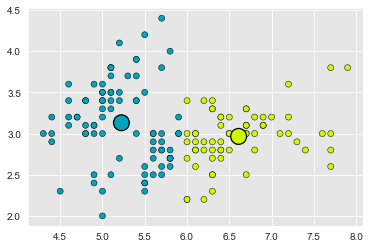

In [22]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X)
y_hat = kmeans.predict(X)

plot_clustering_results(X, y_hat, kmeans.cluster_centers_)

We can also have a look at other values for k:

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


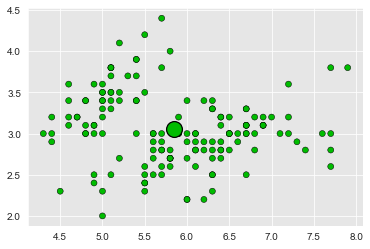

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


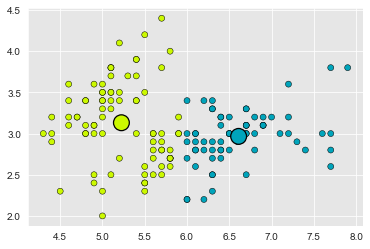

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


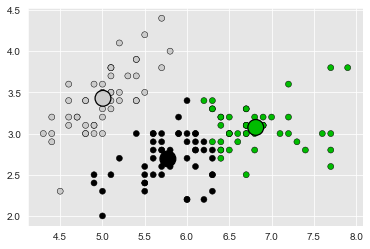

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


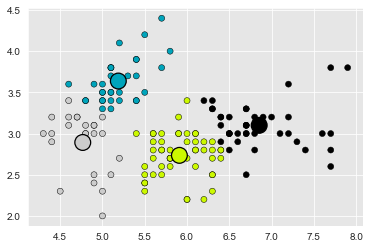

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


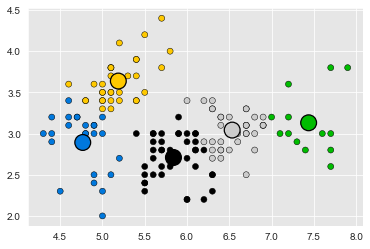

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


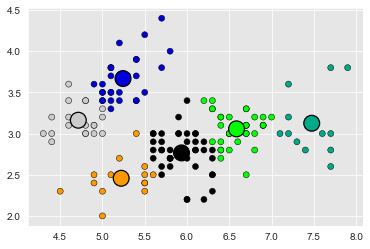

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


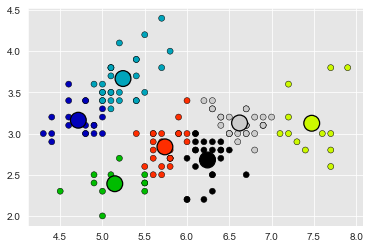

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


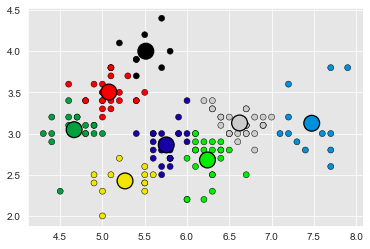

In [23]:
ks = np.linspace(1,8,8).astype(int)

for k in ks:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(X)
    y_hat = kmeans.predict(X)
        
    plot_clustering_results(X, y_hat, kmeans.cluster_centers_)    